In [12]:
from urllib.request import urlopen, Request

FECHA = "20241213"

url = f"https://www.grupoomi.eu/en/file-download?filename=marginalpdbc_{FECHA}.1&parents=marginalpdbc"
req = Request(url, headers={"User-Agent": "Mozilla/5.0"})
raw = urlopen(req).read().decode("latin-1")

lines = [l.strip() for l in raw.splitlines() if l.strip()]

print("TOTAL_LINES:", len(lines))
print("\n--- FIRST 20 LINES ---")
for i, l in enumerate(lines[:20], start=1):
    print(f"{i:02d}: {l}")

print("\n--- FIRST LINE THAT STARTS WITH MARGINALPDBC ---")
for l in lines:
    if l.upper().startswith("MARGINALPDBC"):
        print(l)
        break

TOTAL_LINES: 26

--- FIRST 20 LINES ---
01: MARGINALPDBC;
02: 2024;12;13;1;132.71;132.71;
03: 2024;12;13;2;125;125;
04: 2024;12;13;3;118.97;118.97;
05: 2024;12;13;4;114.95;114.95;
06: 2024;12;13;5;115.64;115.64;
07: 2024;12;13;6;123.96;123.96;
08: 2024;12;13;7;138;138;
09: 2024;12;13;8;154.9;154.9;
10: 2024;12;13;9;164.07;164.07;
11: 2024;12;13;10;163.8;163.8;
12: 2024;12;13;11;150.35;150.35;
13: 2024;12;13;12;145.01;145.01;
14: 2024;12;13;13;141;141;
15: 2024;12;13;14;137.76;137.76;
16: 2024;12;13;15;137.76;137.76;
17: 2024;12;13;16;143.18;143.18;
18: 2024;12;13;17;151.66;151.66;
19: 2024;12;13;18;156.06;156.06;
20: 2024;12;13;19;172.35;172.35;

--- FIRST LINE THAT STARTS WITH MARGINALPDBC ---
MARGINALPDBC;


## Step 1 — Ingesting Spanish day-ahead power prices (OMIE)

The first step was to source reliable, real-world electricity price data for Spain.  
For this, I used OMIE (Operador del Mercado Ibérico de Energía), which publishes official day-ahead market results as public files.

### Data source
OMIE provides daily files containing the hourly clearing prices for the Spanish day-ahead electricity market.  
Each file corresponds to one delivery day and includes one row per hour.

### Approach
- Programmatically download the daily OMIE file for a given date
- Parse the raw text format used by OMIE
- Extract the hourly prices in €/MWh
- Store the data in a clean, analysis-ready structure

### Output
The resulting dataset contains:
- `date`: delivery date (YYYY-MM-DD)
- `hour`: hour of the day (1–24)
- `price_eur_mwh`: day-ahead market price in €/MWh

This produces a structured hourly time series that can be easily extended to a historical range and used as input for forecasting and analysis.

In [49]:
from urllib.request import urlopen, Request
import pandas as pd
from datetime import datetime, timedelta

START_DATE = "2024-10-01"
END_DATE   = "2024-12-13"

def fetch_day_prices(date_yyyy_mm_dd: str) -> pd.DataFrame | None:
    d = datetime.strptime(date_yyyy_mm_dd, "%Y-%m-%d")
    ymd = d.strftime("%Y%m%d")

    url = f"https://www.grupoomi.eu/en/file-download?filename=marginalpdbc_{ymd}.1&parents=marginalpdbc"
    req = Request(url, headers={"User-Agent": "Mozilla/5.0"})
    try:
        raw = urlopen(req).read().decode("latin-1")
    except Exception:
        return None

    lines = [l.strip() for l in raw.splitlines() if l.strip()]
    rows = []

    for l in lines:
        if l.upper().startswith("MARGINALPDBC"):
            continue
        parts = l.split(";")
        if len(parts) < 6:
            continue

        year = int(parts[0]); month = int(parts[1]); day = int(parts[2])
        hour = int(parts[3])
        price = float(parts[4].replace(",", "."))

        rows.append({
            "date": f"{year:04d}-{month:02d}-{day:02d}",
            "hour": hour,
            "price_eur_mwh": price
        })

    if len(rows) == 0:
        return None

    return pd.DataFrame(rows)

start = datetime.strptime(START_DATE, "%Y-%m-%d")
end = datetime.strptime(END_DATE, "%Y-%m-%d")

all_days = []
missing = 0

d = start
while d <= end:
    day_str = d.strftime("%Y-%m-%d")
    df_day = fetch_day_prices(day_str)
    if df_day is None or len(df_day) != 24:
        missing += 1
    else:
        all_days.append(df_day)
    d += timedelta(days=1)

df_all = pd.concat(all_days, ignore_index=True).sort_values(["date", "hour"]).reset_index(drop=True)

df_all.to_csv("data/omie_day_ahead_prices_es_history.csv", index=False)

print("rows:", len(df_all))
print("days_loaded:", df_all["date"].nunique())
print("days_missing_or_incomplete:", missing)
df_all.head(10)

rows: 1752
days_loaded: 73
days_missing_or_incomplete: 1


,date,hour,price_eur_mwh
0,2024-10-01,1,104.00
1,2024-10-01,2,97.68
2,2024-10-01,3,97.68
3,2024-10-01,4,94.86
4,2024-10-01,5,84.01
5,2024-10-01,6,80.35
6,2024-10-01,7,88.13
7,2024-10-01,8,117.04
8,2024-10-01,9,123.81
9,2024-10-01,10,100.00


In [50]:
df_all.tail(10)

,date,hour,price_eur_mwh
1742,2024-12-13,15,137.76
1743,2024-12-13,16,143.18
1744,2024-12-13,17,151.66
1745,2024-12-13,18,156.06
1746,2024-12-13,19,172.35
1747,2024-12-13,20,172.35
1748,2024-12-13,21,172.35
1749,2024-12-13,22,164.52
1750,2024-12-13,23,150.00
1751,2024-12-13,24,140.62


## Step 2 — Building a historical hourly price dataset

After validating the ingestion for a single day, the next step was to construct a continuous historical dataset.

### Approach
- Iterate over a defined date range
- Download the OMIE day-ahead file for each day
- Parse the hourly prices using the same logic as in Step 1
- Skip missing or incomplete days
- Append all valid days into a single dataset

This approach keeps the pipeline simple and robust while handling real-world data issues such as missing files.

### Output
The resulting dataset contains one row per hour and includes:
- `date`: delivery date
- `hour`: hour of the day (1–24)
- `price_eur_mwh`: Spanish day-ahead electricity price in €/MWh

For the selected period, the pipeline successfully loaded 73 complete days of hourly prices, producing a clean time series suitable for exploratory analysis and baseline forecasting.

In [17]:
import pandas as pd
from datetime import timedelta

# --- Prepare daily average prices ---
# Aggregate hourly prices into daily average prices

daily_prices = (
    df_all
    .groupby("date", as_index=False)["price_eur_mwh"]
    .mean()
    .rename(columns={"price_eur_mwh": "daily_avg_price"})
)

daily_prices["date"] = pd.to_datetime(daily_prices["date"])
daily_prices = daily_prices.sort_values("date").reset_index(drop=True)


# --- Baseline definition ---
# Rolling mean over the last N days

ROLLING_WINDOW_DAYS = 14
daily_prices["rolling_mean"] = (
    daily_prices["daily_avg_price"]
    .rolling(ROLLING_WINDOW_DAYS)
    .mean()
)


# --- Compute weekday adjustment factors ---
# Capture systematic differences between weekdays and weekends

daily_prices["weekday"] = daily_prices["date"].dt.weekday
weekday_avg = daily_prices.groupby("weekday")["daily_avg_price"].mean()
weekday_factor = weekday_avg / weekday_avg.mean()


# --- Generate next-week forecast ---
# Use the latest rolling mean as the base level
# Apply weekday adjustment to avoid a flat forecast

last_available_date = daily_prices["date"].max()
forecast_dates = pd.date_range(
    start=last_available_date + timedelta(days=1),
    periods=7,
    freq="D"
)

baseline_value = daily_prices["rolling_mean"].iloc[-1]

forecast_next_week = pd.DataFrame({
    "date": forecast_dates
})

forecast_next_week["weekday"] = forecast_next_week["date"].dt.weekday

forecast_next_week["forecast_daily_avg_price"] = (
    forecast_next_week["weekday"]
    .map(weekday_factor)
    * baseline_value
).round(2)

forecast_next_week[["date", "forecast_daily_avg_price"]]

,date,forecast_daily_avg_price
0,2024-12-14,99.50
1,2024-12-15,79.38
2,2024-12-16,120.27
3,2024-12-17,127.30
4,2024-12-18,123.16
5,2024-12-19,125.69
6,2024-12-20,132.46


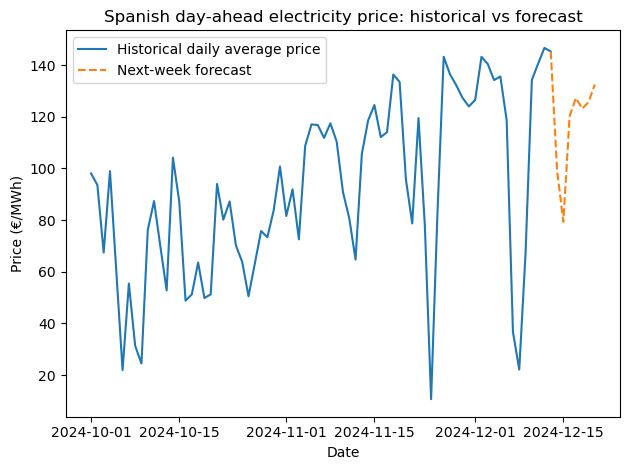

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Last historical point
last_hist_date = daily_prices["date"].iloc[-1]
last_hist_value = daily_prices["daily_avg_price"].iloc[-1]

# Create a connected forecast series
forecast_plot = pd.concat([
    pd.DataFrame({
        "date": [last_hist_date],
        "price": [last_hist_value]
    }),
    pd.DataFrame({
        "date": forecast_next_week["date"],
        "price": forecast_next_week["forecast_daily_avg_price"]
    })
])

plt.figure()

# Historical series
plt.plot(
    daily_prices["date"],
    daily_prices["daily_avg_price"],
    label="Historical daily average price"
)

# Forecast series (connected)
plt.plot(
    forecast_plot["date"],
    forecast_plot["price"],
    linestyle="--",
    label="Next-week forecast"
)

plt.xlabel("Date")
plt.ylabel("Price (€/MWh)")
plt.title("Spanish day-ahead electricity price: historical vs forecast")
plt.legend()
plt.tight_layout()
plt.show()


## Step 3A — Next-week daily price forecast

The objective of this step is to build a **simple and explainable forecast** for Spanish day-ahead electricity prices that can be used as a benchmark.

Rather than starting with a complex model, I focus on a baseline that reflects how prices have behaved recently and how they typically differ across the week.

### From hourly prices to daily prices
OMIE publishes one price per hour (24 values per day).  
To work at a planning-friendly level, I first aggregate these into **daily average prices**:

- Daily average price = mean of the 24 hourly prices for that date

This reduces noise and makes day-to-day comparisons clearer.

### Baseline level: rolling mean
The core of the forecast is a **rolling mean over the last 14 days**.

This answers a simple question:
> “Based on recent history, what price level should I reasonably expect going forward?”

Using a rolling mean:
- smooths short-term volatility,
- avoids reacting to one-off spikes,
- and produces a stable, easy-to-interpret reference level.

### Why a weekday adjustment is applied
If the rolling mean is used on its own, the forecast becomes flat (the same value every day).  
While this is technically valid for a baseline, it ignores a well-known pattern in electricity markets: **not all weekdays behave the same**.

To capture this without adding complexity, I apply a **weekday adjustment factor**.

For each weekday (Monday=0 to Sunday=6):
- I compute the average daily price for that weekday across the historical period
- I compare it to the overall historical average
- The ratio between the two becomes the adjustment factor

Interpretation:
- A factor above 1 means that weekday tends to be more expensive than average
- A factor below 1 means it tends to be cheaper than average

### Final forecast logic
For each day in the next week:

- Forecast daily price = rolling mean baseline × weekday adjustment factor

This keeps the forecast:
- simple,
- transparent,
- and aligned with real market behaviour.

The output is a **7-day forecast of daily average Spanish day-ahead prices**, suitable as a reference point for planning or further modelling.

In [25]:
# --- Sanity checks: intermediate calculations and outputs ---

# Check date coverage of the dataset
print("Date range covered:")
print(daily_prices["date"].min().date(), "to", daily_prices["date"].max().date())

# Inspect recent daily average prices
print("\nRecent daily average prices (last 10 days):")
display(daily_prices[["date", "daily_avg_price"]].tail(10))

# Inspect the rolling mean values used as the baseline level
print("\nRolling mean values (baseline level):")
display(daily_prices[["date", "rolling_mean"]].tail(5))

# Inspect weekday averages and adjustment factors
print("\nWeekday adjustment factors (Monday=0 ... Sunday=6):")
weekday_table = pd.DataFrame({
    "weekday": weekday_avg.index,
    "weekday_avg_price": weekday_avg.values.round(2),
    "adjustment_factor": weekday_factor.values.round(4),
})
display(weekday_table)

# Inspect the final next-week forecast
print("\nNext-week daily average price forecast:")
display(forecast_next_week)

Date range covered:
2024-10-01 to 2024-12-13

Recent daily average prices (last 10 days):


,date,daily_avg_price
63,2024-12-04,134.222917
64,2024-12-05,135.619167
65,2024-12-06,118.659583
66,2024-12-07,36.668333
67,2024-12-08,22.188333
68,2024-12-09,67.188750
69,2024-12-10,134.224167
70,2024-12-11,140.609167
71,2024-12-12,146.672917
72,2024-12-13,145.290417



Rolling mean values (baseline level):


,date,rolling_mean
68,2024-12-09,113.421190
69,2024-12-10,112.776815
70,2024-12-11,113.073631
71,2024-12-12,114.108214
72,2024-12-13,115.393304



Weekday adjustment factors (Monday=0 ... Sunday=6):


,weekday,weekday_avg_price,adjustment_factor
0,0,94.77,1.0422
1,1,100.31,1.1032
2,2,97.05,1.0673
3,3,99.04,1.0892
4,4,104.38,1.1479
5,5,78.41,0.8623
6,6,62.55,0.6879



Next-week daily average price forecast:


,date,weekday,forecast_daily_avg_price
0,2024-12-14,5,99.50
1,2024-12-15,6,79.38
2,2024-12-16,0,120.27
3,2024-12-17,1,127.30
4,2024-12-18,2,123.16
5,2024-12-19,3,125.69
6,2024-12-20,4,132.46


## Step 3B — Sanity check

After building the forecast, I validate the logic by applying the same approach to historical data and inspecting both intermediate values and errors.

### Sanity checks
Before looking at metrics, I verify that the intermediate calculations make sense:

- Date range covered by the dataset
- Recent daily average prices
- Rolling mean values used as the baseline level
- Weekday averages and their corresponding adjustment factors
- The final next-week forecast values

This step ensures the pipeline behaves as expected and helps surface any obvious issues early.

In [32]:
# --- Baseline validation on historical data ---

# Rebuild the baseline prediction for historical dates
validation_df = daily_prices.copy()

# Use the previous day's rolling mean as the baseline forecast level
validation_df["baseline_level"] = validation_df["rolling_mean"].shift(1)

# Apply the weekday adjustment factor
validation_df["weekday_factor"] = validation_df["weekday"].map(weekday_factor)

validation_df["baseline_prediction"] = (
    validation_df["baseline_level"] * validation_df["weekday_factor"]
)

# Drop rows where the baseline is not available
validation_df = validation_df.dropna(subset=["baseline_prediction"])

# Error metrics
mae = (validation_df["daily_avg_price"] - validation_df["baseline_prediction"]).abs().mean()
mape = (
    (validation_df["daily_avg_price"] - validation_df["baseline_prediction"]).abs()
    / validation_df["daily_avg_price"]
).mean() * 100

print("MAE (€/MWh):", round(mae, 2))
print("MAPE (%):", round(mape, 2))

# Inspect recent actual vs predicted values
display(
    validation_df[["date", "daily_avg_price", "baseline_prediction"]]
    .tail(10)
    .assign(error=lambda x: (x["daily_avg_price"] - x["baseline_prediction"]).round(2))
)


MAE (€/MWh): 21.88
MAPE (%): 36.56


,date,daily_avg_price,baseline_prediction,error
63,2024-12-04,134.222917,117.269807,16.95
64,2024-12-05,135.619167,122.670341,12.95
65,2024-12-06,118.659583,133.948487,-15.29
66,2024-12-07,36.668333,100.562252,-63.89
67,2024-12-08,22.188333,78.184688,-56.00
68,2024-12-09,67.188750,119.313989,-52.13
69,2024-12-10,134.224167,125.122801,9.10
70,2024-12-11,140.609167,120.365518,20.24
71,2024-12-12,146.672917,123.162469,23.51
72,2024-12-13,145.290417,130.988897,14.30


## Step 3C — Baseline validation

### Historical validation
To evaluate the baseline, I reconstruct predictions for past dates using only information that would have been available at the time:

- The rolling mean is shifted by one day
- The same weekday adjustment factors are applied

This produces a **baseline prediction** for each historical day.

### Understanding the error column
In the validation table, the error is defined as:

- **error = actual daily price − baseline prediction**

Interpretation:
- Positive error → the market was higher than expected (under-prediction)
- Negative error → the market was lower than expected (over-prediction)
- Error close to zero → prediction was close to reality

Looking at the error helps understand not only how large the miss was, but also its direction.

### Metrics used
Two standard metrics are used to summarise performance:

- **MAE (€/MWh)**: average absolute daily error, easy to interpret in price terms
- **MAPE (%)**: average percentage error, useful for comparing across periods

These metrics provide a practical benchmark. The baseline forecast shows a relatively high error level, which is expected given its simplicity and the volatility of electricity prices. These results confirm that the baseline should be treated as a reference point rather than a production-ready forecasting model.


In [37]:
# --- Prepare daily and hourly views ---

df_all["date"] = pd.to_datetime(df_all["date"])
df_all["weekday"] = df_all["date"].dt.weekday
df_all["is_weekend"] = df_all["weekday"] >= 5

# Daily aggregation
daily_stats = (
    df_all
    .groupby("date")
    .agg(
        daily_avg_price=("price_eur_mwh", "mean"),
        daily_min_price=("price_eur_mwh", "min"),
        daily_max_price=("price_eur_mwh", "max"),
        daily_std=("price_eur_mwh", "std"),
    )
    .reset_index()
)

# --- 1) Overall price level ---
overall_summary = daily_stats.agg({
    "daily_avg_price": ["mean", "min", "max"],
    "daily_std": ["mean"]
}).round(2)

print("Overall price summary:")
display(overall_summary)


# --- 2) Weekday vs weekend ---
weekday_summary = (
    df_all
    .groupby("is_weekend")["price_eur_mwh"]
    .mean()
    .reset_index()
)

weekday_summary["day_type"] = weekday_summary["is_weekend"].map({
    False: "Weekday",
    True: "Weekend"
})

print("\nWeekday vs weekend average prices:")
display(weekday_summary[["day_type", "price_eur_mwh"]].round(2))


# --- 3) Hourly pattern ---
hourly_pattern = (
    df_all
    .groupby("hour")["price_eur_mwh"]
    .mean()
    .reset_index()
    .sort_values("hour")
)

print("\nAverage price by hour:")
display(hourly_pattern.round(2))


# --- 4) Most volatile days ---
volatile_days = (
    daily_stats
    .sort_values("daily_std", ascending=False)
    .head(10)
)

print("\nMost volatile days (top 10):")
display(volatile_days.round(2))

Overall price summary:


,daily_avg_price,daily_std
mean,91.83,23.97
min,10.71,NaN
max,146.67,NaN



Weekday vs weekend average prices:


,day_type,price_eur_mwh
0,Weekday,99.19
1,Weekend,70.90



Average price by hour:


,hour,price_eur_mwh
0,1,91.90
1,2,84.70
2,3,80.16
3,4,76.34
4,5,74.45
5,6,77.61
6,7,88.01
7,8,102.90
8,9,111.68
9,10,100.19



Most volatile days (top 10):


,date,daily_avg_price,daily_min_price,daily_max_price,daily_std
54,2024-11-25,82.01,3.33,159.82,55.84
68,2024-12-09,67.19,3.85,137.21,51.99
41,2024-11-12,64.74,3.32,128.86,44.90
9,2024-10-10,76.18,39.83,180.00,42.69
19,2024-10-20,51.29,0.02,125.89,38.99
4,2024-10-05,60.40,0.00,109.38,38.59
12,2024-10-13,52.78,0.11,121.28,36.74
32,2024-11-03,72.57,7.40,116.67,33.59
16,2024-10-17,51.25,0.44,84.80,33.22
0,2024-10-01,98.07,56.28,173.81,32.32


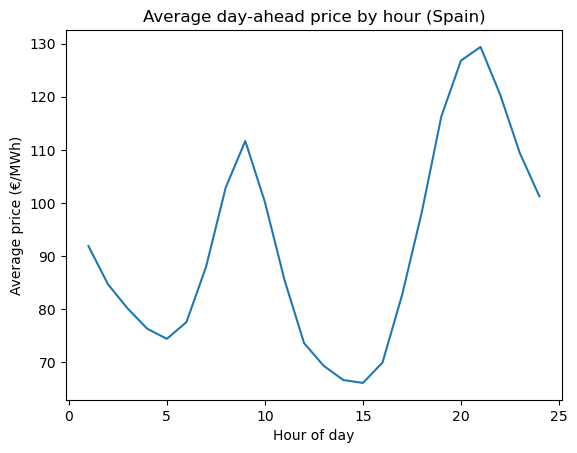

In [43]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(
    hourly_pattern["hour"],
    hourly_pattern["price_eur_mwh"]
)
plt.xlabel("Hour of day")
plt.ylabel("Average price (€/MWh)")
plt.title("Average day-ahead price by hour (Spain)")
plt.show()

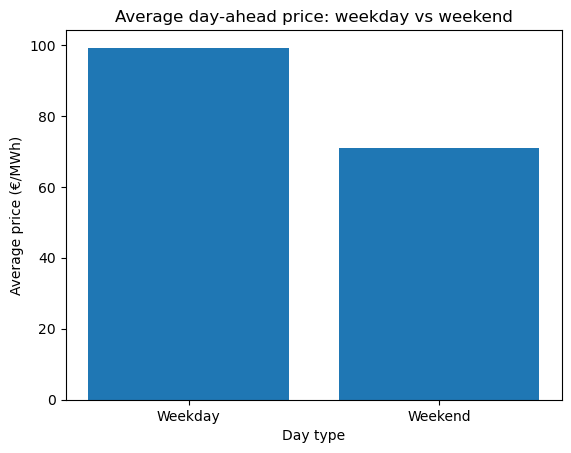

In [45]:
plt.figure()
plt.bar(
    weekday_summary["day_type"],
    weekday_summary["price_eur_mwh"]
)
plt.xlabel("Day type")
plt.ylabel("Average price (€/MWh)")
plt.title("Average day-ahead price: weekday vs weekend")
plt.show()

## Insights from the historical period

This section highlights the main takeaways from the OMIE Spanish day-ahead price data over the analysed period.

### Price level and volatility
The average daily price is **91.83 €/MWh**, with daily averages ranging from **10.71 €/MWh** to **146.67 €/MWh**.  
Average intraday volatility is **23.97 €/MWh**, indicating meaningful price swings within a single day.

**Key takeaway:**  
Price levels and volatility vary significantly even over short periods, making regular monitoring essential.

---

### Weekday vs weekend behaviour
- **Average weekday price:** 99.19 €/MWh  
- **Average weekend price:** 70.90 €/MWh  

Weekend prices are materially lower than weekday prices.

**Key takeaway:**  
This systematic gap reflects demand patterns and supports the use of a weekday adjustment in the forecast.

---

### Intraday price pattern
Prices are lowest in the early morning and early afternoon, and peak in the evening, around **hours 20–21**, where average prices exceed **125 €/MWh**.

**Key takeaway:**  
Evening hours consistently represent the highest-cost and highest-exposure period of the day.

---

### Volatility concentration
A small number of days exhibit very high intraday volatility (daily standard deviation above **50 €/MWh**), such as **2024-11-25** and **2024-12-09**.

**Key takeaway:**  
Risk is concentrated in a limited set of high-volatility days, making them strong candidates for targeted monitoring and alerts.
